
# E2 - Data Drift in Used Vehicle Price Prediction

## Introduction

- 1.2 Million listings scraped from TrueCar.com - Price, Mileage, Make, Model dataset from Kaggle: [data](https://www.kaggle.com/jpayne/852k-used-car-listings)
- Each observation represents the price of an used car

In [388]:
%matplotlib inline
import pandas as pd

In [389]:
from sklearn.model_selection import KFold,  GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [390]:
data = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTrain_carListings.zip')

In [391]:
#data.head()
#data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Price    500000 non-null  int64 
 1   Year     500000 non-null  int64 
 2   Mileage  500000 non-null  int64 
 3   State    500000 non-null  object
 4   Make     500000 non-null  object
 5   Model    500000 non-null  object
dtypes: int64(3), object(3)
memory usage: 22.9+ MB


In [392]:
#data.columns

# Exercise P0.1 (20%)

Complete an exploratory data analysis with the variables in the dataset to determine the relationships between the vehicle price (target feature) and the other features. Remember to separate the analysis between bivariate and multivariate, in order to see the effects of each feature separately and then with a set of features.

In [393]:
data.isnull().sum()

Price      0
Year       0
Mileage    0
State      0
Make       0
Model      0
dtype: int64

In [394]:
data.Price.describe()

count    500000.000000
mean      21144.186304
std       10753.259704
min        5001.000000
25%       13499.000000
50%       18450.000000
75%       26998.000000
max       79999.000000
Name: Price, dtype: float64

Análisis Bivariado

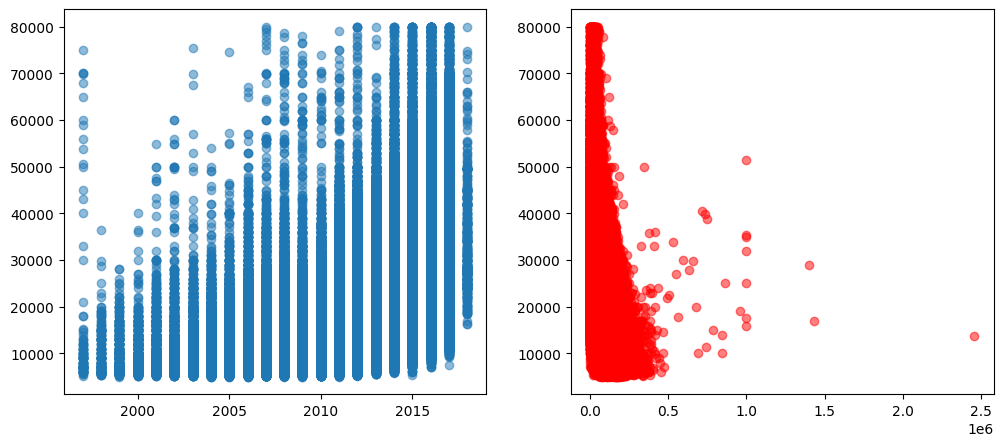

In [395]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].scatter(data['Year'], data['Price'], alpha=0.5) #Relacion Año y Precio
axes[1].scatter(data['Mileage'], data['Price'], alpha=0.5, color='red') #Relacion Mileage y Precio
plt.show()

Análisis Univariado

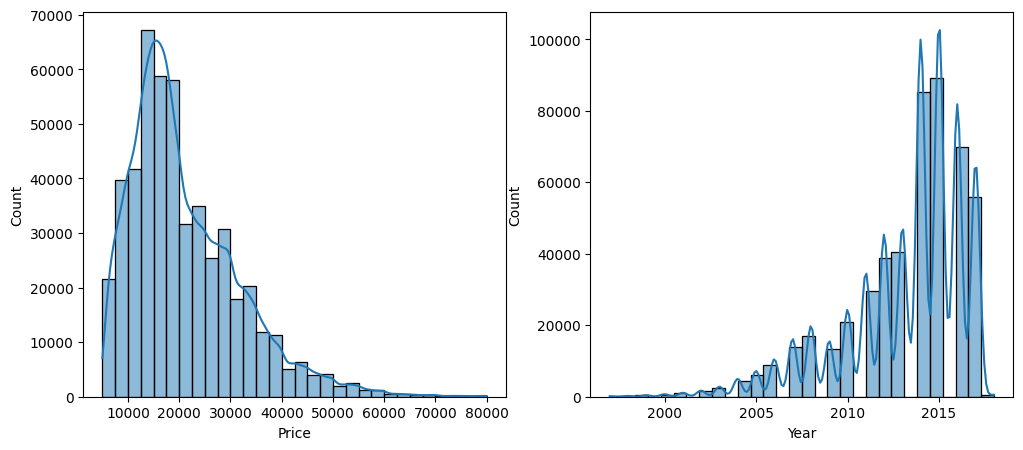

In [396]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.histplot(data['Price'], bins=30, kde=True, ax=axes[0]) # Distribución Precio
sns.histplot(data['Year'], bins=30, kde=True, ax=axes[1]) # Distribución Year
plt.show()

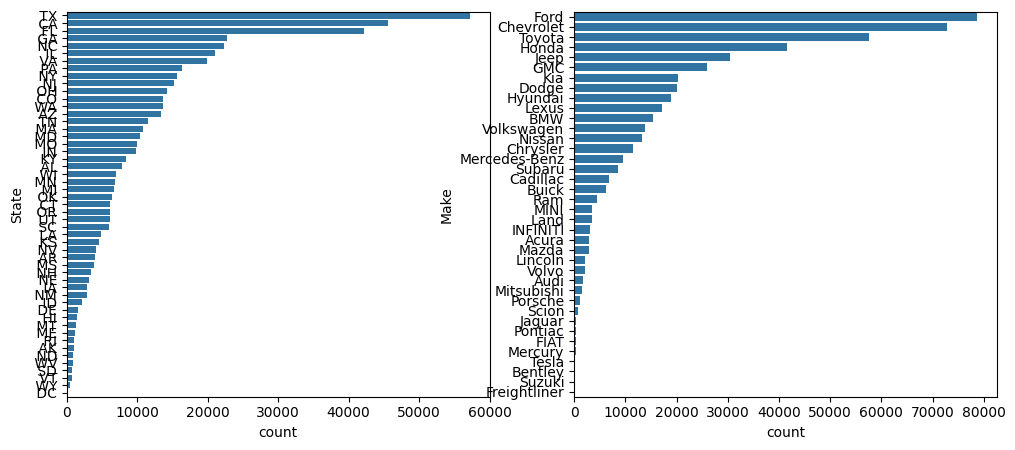

In [397]:
categorical_features = ['State', 'Make'] # Distribución de Variables 'State', 'Make'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5)) 
sns.countplot(y=data['State'], ax=axes[0], order=data['State'].value_counts().index)
sns.countplot(y=data['Make'], ax=axes[1], order=data['Make'].value_counts().index)
plt.show()

Análisis Bivariado - Variables Categoricas

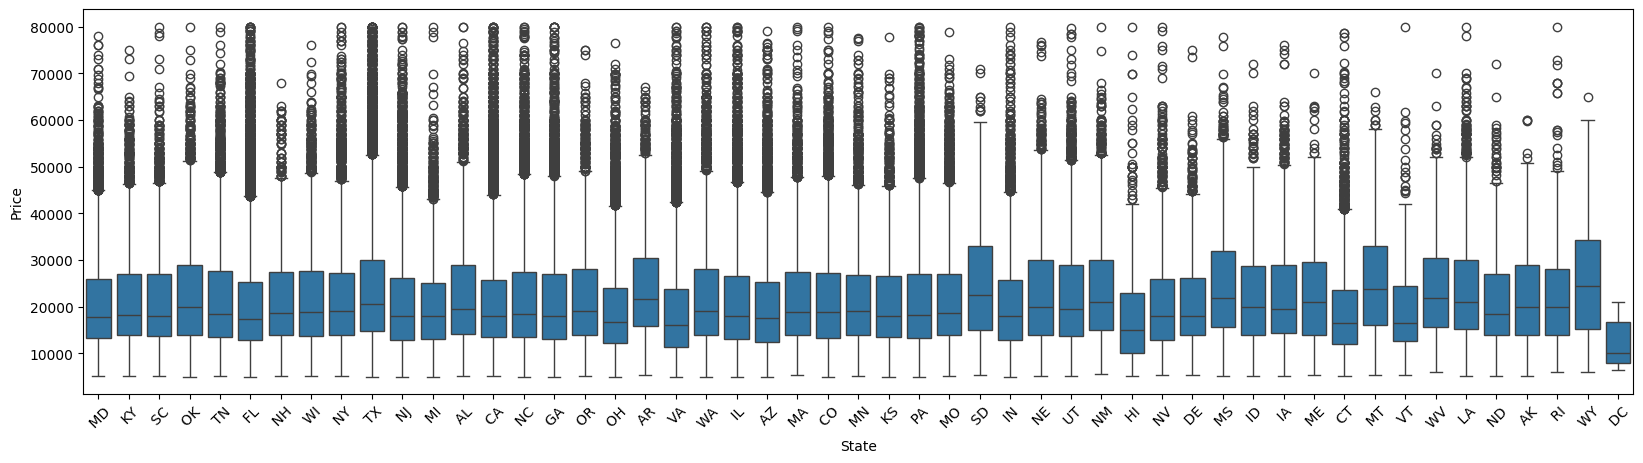

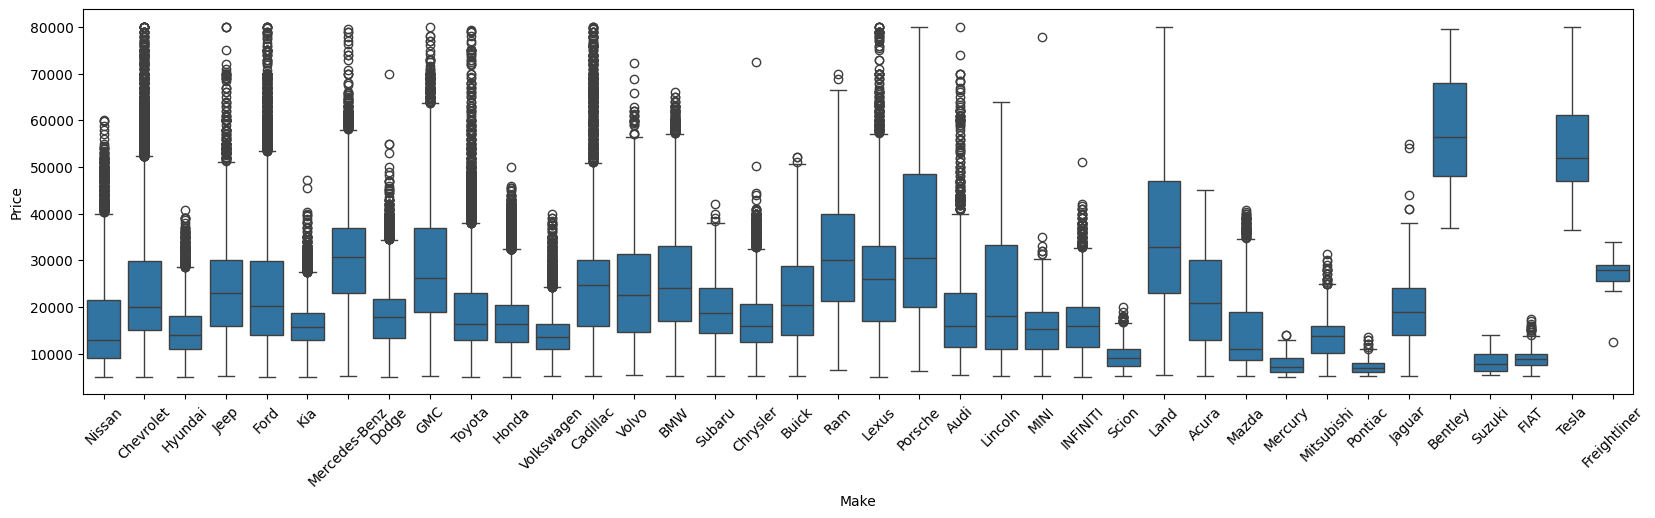

In [398]:
for feature in categorical_features:
    plt.figure(figsize=(20, 5))
    sns.boxplot(x=data[feature], y=data['Price'])
    #plt.title(f'Distribución del Precio por {feature}')
    plt.xticks(rotation=45)
    plt.show()

Análisis Multivariables

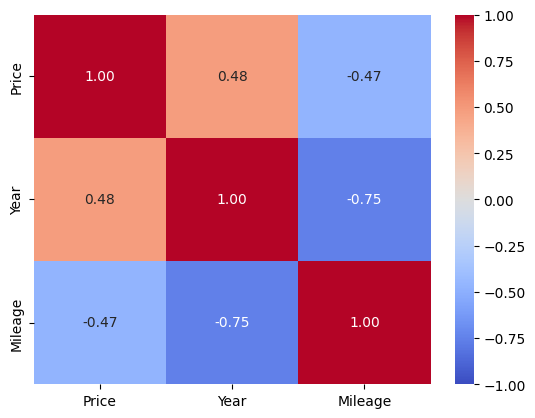

In [399]:
numeric_columns = data.select_dtypes(include=[np.number])
correlation_matrix = numeric_columns.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.show()

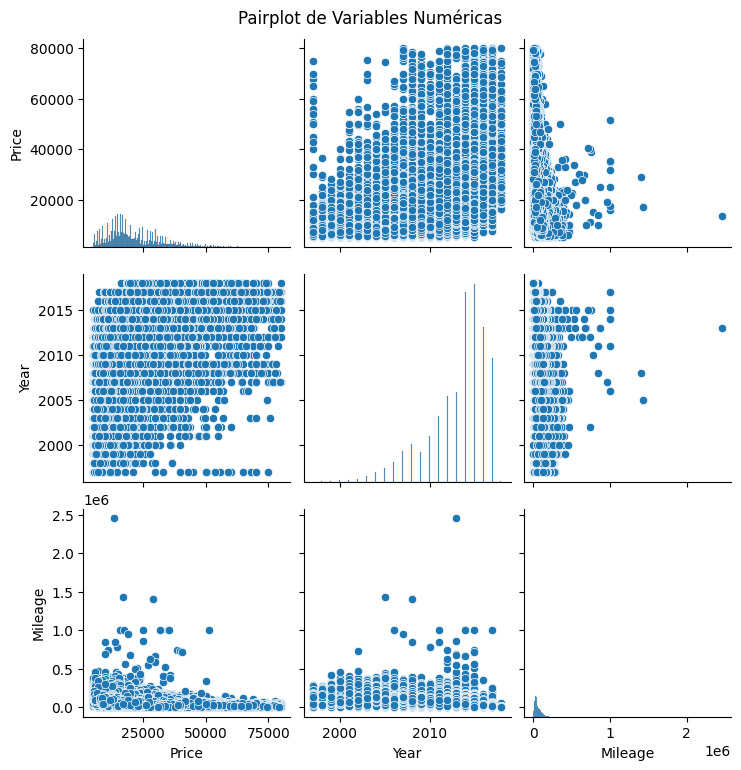

In [400]:
# Pairplot para variables numéricas
sns.pairplot(data[['Price', 'Year', 'Mileage']])
plt.suptitle('Pairplot de Variables Numéricas', y=1.02)
plt.show()

## Exercise P0.2 (20%)




Develop a machine learning model that predicts the price of the of car using as an input ['Year', 'Mileage', 'State', 'Make', 'Model'] **train model with data until 2010**.

*Evaluation:*

* 10% - Performance of the models using a manually implemented K-Fold (K=10) cross-validation
* 10% - Notebook explaining the process for selecting the best model. You must specify how the calibration of each of the parameters is done and how these change the performance of the model. It is expected that a clear comparison will be made of all implemented models.. Present the most relevant conslusions about the whole process.

Feature engineering

In [401]:
target_name = 'Price'
numeric_features=['Mileage']
categorical_features=['Year', 'Mileage', 'State', 'Make', 'Model']

Limpieza de Atipicos

In [402]:
percentile_95 = data['Price'].quantile(0.95)
df = data[data['Price'] <= percentile_95]

Universo de datos

In [403]:
#df = df[df['Make'].isin(['Bentley', 'Porsche', 'Land', 'GMC', 'Jaguar'])] # Filtrar el DataFrame por marca de lujo
df = df[df['Make'].isin(['Porsche'])] # Filtrar el DataFrame por marca de lujo

df_before = df[df['Year'] <= 2010]
df_after=df[df['Year'] > 2010]

In [404]:
X_train = df[categorical_features]
y_train = df[target_name]

X_test = df_after[categorical_features]
y_test = df_after[target_name]

One-hot encoding

In [405]:
# One-hot encoding para variables categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['Year','State', 'Make', 'Model'])
    ],
    remainder='passthrough'
)

In [406]:
X_train = preprocessor.fit_transform(X_train)
if hasattr(X_train, 'toarray'):
    X_train = X_train.toarray()

X_test = preprocessor.fit_transform(X_test)
if hasattr(X_test, 'toarray'):
    X_test = X_test.toarray()

Escalado

In [407]:
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.fit_transform(X_test)

Modelo

Regresión Lineal, Arboles de Decisión y Random Forest

In [408]:
semilla=123

models = {
    'Linear Regression': (LinearRegression(), {}),
    'Decision Tree': (DecisionTreeRegressor(random_state=semilla), {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}),
    'Random Forest': (RandomForestRegressor(random_state=semilla, n_jobs=-1), {'n_estimators': [100, 200], 'max_depth': [None, 5, 10]}),
}

# Inicializar KFold
kf = KFold(n_splits=10, shuffle=True, random_state=semilla)

results = []
all_predictions = pd.DataFrame()

# Evaluar cada modelo
for model_name, (model, param_grid) in models.items():
    mae_scores = []
    model_predictions = np.zeros(X_train.shape[0])

    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Realizar ajuste de hiperparámetros usando GridSearchCV
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error')
        grid_search.fit(X_train_fold, y_train_fold)

        # Obtener el mejor modelo
        best_model = grid_search.best_estimator_

        # Predecir y calcular el MAE
        y_pred = best_model.predict(X_val_fold)
        mae = mean_absolute_error(y_val_fold, y_pred)
        mae_scores.append(mae)

        # Guardar las predicciones
        model_predictions[val_index] = y_pred

    # Combinar todas las predicciones del fold en un DataFrame
    all_predictions[model_name] = model_predictions


    average_mae = np.mean(mae_scores)
    results.append({'Model': model_name, 'Mean Absolute Error (MAE)': average_mae})

# Crear un DataFrame con los resultados
results_df = pd.DataFrame(results)

# Mostrar la tabla comparativa
print(results_df)
print(all_predictions.head())

               Model  Mean Absolute Error (MAE)
0  Linear Regression               5.594344e+15
1      Decision Tree               3.542392e+03
2      Random Forest               3.213554e+03
   Linear Regression  Decision Tree  Random Forest
0       29894.320312   31844.250000   29089.675000
1       29715.124408   26488.000000   29474.495000
2       27272.875000   26381.627451   29189.070000
3       23088.875000   22294.000000   23929.945000
4       24643.919743   24100.577778   21906.473333


In [409]:
base = df_after.drop(columns=[target_name])

In [410]:
all_predictions = all_predictions.astype(int)
Price = pd.Series(all_predictions['Linear Regression'], name='Price')
Predictions = pd.concat([base.reset_index(drop=True), Price.reset_index(drop=True)], axis=1)
print(Predictions.head())

     Year  Mileage State     Make       Model  Price
0  2011.0  86315.0    IL  Porsche  CayenneAWD  29894
1  2011.0  62899.0    CA  Porsche  CayenneAWD  29715
2  2011.0  59556.0    CA  Porsche   Cayman2dr  27272
3  2012.0  76915.0    WA  Porsche  CayenneAWD  23088
4  2014.0  36661.0    AZ  Porsche  CayenneAWD  24643


## Exercise P0.3 (60%)




Make a drift analysis on the target, model and other features to identify whether there is drift in the target or model or its features after 2011.

*Evaluation:*
- 20% - Target drift analysis. Is there drift over car price?
- 20% - Data drift analysis. Is there drift over model features?
- 20% - Model drift analysis. You must make the predictions on the remaining data (after 2011) and validate if there is drift in the model performance over the same train metrics.

In [411]:
from sklearn.datasets import fetch_openml
from evidently import ColumnMapping
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

In [417]:
data_drift_report = Report(metrics=[
    DataDriftPreset(),
])

numerical_features = ['Mileage', 'Price']
categorical_features = ['Year', 'Model', 'State', 'Make']
column_mapping = ColumnMapping(numerical_features=numerical_features, categorical_features=categorical_features)


reference_data = df_after
current_data = df_before

column_mapping = ColumnMapping(numerical_features=numerical_features, categorical_features=categorical_features)

data_drift_report.run(
    reference_data=reference_data,
    current_data=current_data,
    column_mapping=column_mapping
)

data_drift_report

c:\Users\marce\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:8022: RuntimeWarning:

divide by zero encountered in divide

c:\Users\marce\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:8022: RuntimeWarning:

divide by zero encountered in divide

c:\Users\marce\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:8022: RuntimeWarning:

divide by zero encountered in divide

c:\Users\marce\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:8022: RuntimeWarning:

divide by zero encountered in divide

c:\Users\marce\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:8022: RuntimeWarning:

divide by zero encountered in divide

c:\Users\marce\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:8022: RuntimeWarning:

divide by zero encountered in divide



In [416]:
numerical_features = ['Mileage', 'Price']
categorical_features = ['Year', 'Model', 'State', 'Make']
column_mapping = ColumnMapping(numerical_features=numerical_features, categorical_features=categorical_features)


reference_data = df_after
current_data = Predictions

column_mapping = ColumnMapping(numerical_features=numerical_features, categorical_features=categorical_features)

data_drift_report.run(
    reference_data=reference_data,
    current_data=current_data,
    column_mapping=column_mapping
)

data_drift_report

## BONUS:

Perform drfit dashboard!